<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Understanding and working with the Landlab Landslide Component Unit Tests 


<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This Jupyter Notebook runs the unit tests for the Landlab LandslideProbability component on a synthetic Landlab grid. Depth to Groundwater is included as a hydrologic forcing options to using the four recharge options as described in the paper: <br />
Strauch et al. 2018. A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6, 1-26. <br /> 

## 0.  Software Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

In [1]:
#import Python utilities for calculating and plotting
import numpy as np
import matplotlib.pyplot as plt

#import Landlab
from landlab import RasterModelGrid
from landlab.components import landslides
from landlab.components.landslides import LandslideProbability
from landlab.plot import imshow_grid
from landlab.io import read_esri_ascii

import plot_landslides as pl
import tests.components.landslides.test_landslide_probability as test
from numpy.testing import assert_array_almost_equal


## 1. Create a synthetic grid and data fields used to calculate landslide probability

**Unit Test - new function added for Version 2** 

`test_build_grid_unitarea()`

This example uses a synthetic model domain. 

As a first example, make a synthetic grid with 5 rows and 4 columns.

units 10 m x 10 m grid cell (grid: 5 rows, 4 columns).

In [2]:
synthetic_unitgrid = test.test_build_grid_unitarea()  

We can also see how many core nodes we have (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'. Compare this array to the full grid above.  Asign these to the variable 'core_nodes' so we can use these later.

In [3]:
gridnum = synthetic_unitgrid.number_of_nodes
print('The synthetic grid has {value} total grid cells (nodes), including the boundary nodes.'.format(value=synthetic_unitgrid.number_of_nodes)) 
print('The synthetic grid has {value} m grid cell size.'.format(value=synthetic_unitgrid.dx)) 
grid_cnum = synthetic_unitgrid.number_of_core_nodes
print("Core nodes are the center of a Landlab model grid.")
print("Landslide calculations are made only on {value} core nodes.".format(value=grid_cnum))
print("This is the array of Landlab node values used to index the core nodes (dictionary key)")
synthetic_unitgrid.core_nodes

The synthetic grid has 20 total grid cells (nodes), including the boundary nodes.
The synthetic grid has 10.0 m grid cell size.
Core nodes are the center of a Landlab model grid.
Landslide calculations are made only on 6 core nodes.
This is the array of Landlab node values used to index the core nodes (dictionary key)


array([ 5,  6,  9, 10, 13, 14])

#### `ls_prob` is the model instance (initialization) for the testing

Use the component to create a Landslide model instance on the synthetic unit grid so that we can continue the component tests with `ls_prob` using the `synthetic_unitgrid`. 

In [4]:
ls_prob = LandslideProbability(synthetic_unitgrid)

**Unit Test for big grids - new function added for Version 2** 

Test that we can change the input dimensions and keep the other defaults using `test_build_unitgrid()` for any area and grid size that we want to create a synthetic landslide model.  This is useful for testing the computuational demand and designing big tests. 

In [5]:
(rowcol, edgelength, coordinates) = ((100, 100), (10e0, 10e0), (0.0, 0.0))
dimensions = (rowcol, edgelength, coordinates)
synthetic_grid = test.test_build_unitgrid(rowcol, edgelength)  
print("Core nodes are the center of a Landlab model grid.")
print("Landslide calculations are made only on {value} core nodes.".format(value=synthetic_grid.number_of_core_nodes))
print("What is the runtime? What is the computational cost?")

Core nodes are the center of a Landlab model grid.
Landslide calculations are made only on 9604 core nodes.
What is the runtime? What is the computational cost?


**Unit Test functions for grid and node**  

In [6]:
print('We created a Landlab RasterModelGrid: {value}. '.format(value=synthetic_unitgrid))
synthetic_unitgrid

We created a Landlab RasterModelGrid: <xarray.Dataset>
Dimensions:         (Two: 2, cell: 6, face: 17, link: 31, max_patch_links: 4, node: 20, patch: 12)
Coordinates:
  * node            (node) int32 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
Dimensions without coordinates: Two, cell, face, link, max_patch_links, patch
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 0.0 0.0 0.0 0.0 10.0 ... 40.0 40.0 40.0 40.0
    x_of_node       (node) float64 0.0 10.0 20.0 30.0 0.0 ... 0.0 10.0 20.0 30.0
    nodes_at_link   (link, Two) int32 0 1 1 2 2 3 0 4 ... 19 16 17 17 18 18 19
    links_at_patch  (patch, max_patch_links) int32 4 7 3 0 5 ... 22 27 30 26 23
    node_at_cell    (cell) int32 5 6 9 10 13 14
    nodes_at_face   (face, Two) int32 1 5 2 6 4 5 5 6 ... 14 14 15 13 17 14 18. 


RasterModelGrid((5, 4), xy_spacing=(10.0, 10.0), xy_of_lower_left=(0.0, 0.0))

To read more documentation about this dataset type:

Use `RasterModelGrid?` OR `synthetic_unitgrid?` OR uncomment cell below .

In [7]:
#synthetic_unitgrid?

The Landlab grid variable we input to `LandslideProbability` is the `synthetic_unitgrid`

In [8]:
print('Input `synthetic_unitgrid` size: rows = {value}; cols = {value2}. '.format(
    value=synthetic_unitgrid.number_of_node_rows,
    value2=synthetic_unitgrid.number_of_node_columns))

rowcol=[synthetic_unitgrid.number_of_node_rows,synthetic_unitgrid.number_of_node_columns]
edgelength=[synthetic_unitgrid.dx,synthetic_unitgrid.dy]
coordinates=synthetic_unitgrid.xy_of_lower_left

dimensions = (rowcol, edgelength, coordinates)


Input `synthetic_unitgrid` size: rows = 5; cols = 4. 


In [9]:
print('Landlab grid dimensions to test the Landslide model instance: {value}. '.format(value=dimensions))


Landlab grid dimensions to test the Landslide model instance: ([5, 4], [10.0, 10.0], (0.0, 0.0)). 


In [10]:
test.test_grid_shape(ls_prob,dimensions)
test.test_grid_x_extent(ls_prob,dimensions)
test.test_grid_y_extent(ls_prob,dimensions)
test.test_field_getters(ls_prob,dimensions)

If there are no assertion errors printed, the unit test passes since 

`_SHAPE[0]`(see Unit Test test_landslide_probability.py) == `synthetic_unitgrid[0]` == `ls_prob.grid.shape[0]` 

**Unit Test function**  `test_name()`  - is the name "Landslide Probability" ?

In [11]:
test.test_name(ls_prob)

Check the list of data inputs that the component needs.

**Unit Test function**  `test_input_var_names()` testing that `input_var_names()` outputs correctly.

In [12]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

In [13]:
test.test_input_var_names(ls_prob)

**Unit Test function**  `test_output_var_names()` testing that `output_var_names()` outputs correctly.

In [14]:
sorted(LandslideProbability.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_recharge',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

In [15]:
test.test_output_var_names(ls_prob)

Review the details of the additional outputs to  Version 2:mean depth and mean recharge.  A distribution of values is given as an input; the output is the mean per node for plotting. 

In [16]:
LandslideProbability.var_help('soil__mean_watertable_depth')

name: soil__mean_watertable_depth
description:
  Mean depth to water table from surface to perched water table within
  the soil layer
units: m
unit agnostic: False
at: node
intent: out


In [17]:
LandslideProbability.var_help('soil__mean_recharge')

name: soil__mean_recharge
description:
  Mean recharge to the soil layer
units: mm/day
unit agnostic: False
at: node
intent: out


**Unit Test function**  `test_var_units()` testing unit dimensions (string).

In [18]:
test.test_var_units(ls_prob)

**Unit Test function**  `test_field_initialized_to_zero()` and  `test_field_initialized_to_range()` testing input parameter initialization of fields for outputs (zero) and inputs (default range).

In [19]:
test.test_field_initialized_to_zero(ls_prob,LandslideProbability.output_var_names)

Uncomment cell below to verify the output values are all zeros (initialized, but model not run yet).

In [20]:
#pl.print_list_nodevalues(ls_prob,LandslideProbability.output_var_names)

To review and change default values, create a dictionary of default values.

(see also Unit Test in landlab/tests/test_landslide_probability.py for range of OUTPUTS used in tests)

In [21]:
#pl.print_nodevalues(ls_prob)

In [22]:
value_list=['landslide__probability_of_failure','soil__mean_relative_wetness']
test.print_list_nodevalues(ls_prob, value_list)

Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]

Input: (Min, Max) range of default soil__mean_relative_wetness model inputs: (0, 1)
Ouput: soil__mean_relative_wetness default value initialized for each node:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]



In [23]:
value_list = ['soil__saturated_hydraulic_conductivity','soil__transmissivity','soil__thickness']

test.print_list_nodevalues(ls_prob, value_list)

Input: (Min, Max) range of default soil__saturated_hydraulic_conductivity model inputs: (0.1, 100.0)
Ouput: soil__saturated_hydraulic_conductivity default value initialized for each node:
[ 74.8826363   66.29597008  52.29619267  42.36930228  34.35577694
  20.65252391  18.72602461  18.24677006  16.13892571  12.82809754
  10.86309331  10.25122133   9.29733171   6.73338595   6.18287432
   4.98089536   3.2099719    0.34815856   0.12521729   0.11684311]

Input: (Min, Max) range of default soil__transmissivity model inputs: (0.1, 10)
Ouput: soil__transmissivity default value initialized for each node:
[ 9.85768159  9.8165405   9.23522118  8.71778256  8.15595153  8.04471916
  7.8171944   7.73145546  7.02845178  6.43397224  5.8188623   5.50991933
  5.20317886  4.90081764  4.74793488  4.04955356  2.6650662   0.32703762
  0.1219207   0.11625751]

Input: (Min, Max) range of default soil__thickness model inputs: (0.1, 1)
Ouput: soil__thickness default value initialized for each node:
[ 0.13164175 

In [24]:
value_list = ['soil__minimum_total_cohesion','soil__maximum_total_cohesion','soil__mode_total_cohesion']
test.print_list_nodevalues(ls_prob, value_list)


Input: (Min, Max) range of default soil__minimum_total_cohesion model inputs: (27, 897)
Ouput: soil__minimum_total_cohesion default value initialized for each node:
[771  58  59 359 199 425 202 121 877 162 241 555  91 291 501  71 665 704
 121 486]

Input: (Min, Max) range of default soil__maximum_total_cohesion model inputs: (33, 903)
Ouput: soil__maximum_total_cohesion default value initialized for each node:
[777  64  65 365 205 431 208 127 883 168 247 561  97 297 507  77 671 710
 127 492]

Input: (Min, Max) range of default soil__mode_total_cohesion model inputs: (30, 900)
Ouput: soil__mode_total_cohesion default value initialized for each node:
[774  61  62 362 202 428 205 124 880 165 244 558  94 294 504  74 668 707
 124 489]



In [25]:
test_unit_defaultpars=test.get_default_nodevalues()
test_unit_defaultpars

{'topographic__slope': (0.1, 0.8),
 'topographic__specific_contributing_area': (10, 100),
 'soil__transmissivity': (0.1, 10),
 'soil__mode_total_cohesion': (30, 900),
 'soil__minimum_total_cohesion': (27, 897),
 'soil__maximum_total_cohesion': (33, 903),
 'soil__internal_friction_angle': (26, 37),
 'soil__thickness': (0.1, 1),
 'soil__density': (1999, 2001),
 'soil__saturated_hydraulic_conductivity': (0.1, 100.0),
 'landslide__probability_of_failure': (0, 1),
 'soil__mean_relative_wetness': (0, 1),
 'soil__mean_watertable_depth': (0, 1000),
 'soil__mean_recharge': (0, 1000),
 'soil__probability_of_saturation': (0, 1)}

In [26]:
test.test_field_initialized_to_range(ls_prob,LandslideProbability.input_var_names,test_unit_defaultpars)

Uncomment the box below to review ALL the details of what each variable represents.  
Close the window with the upper right [x] after viewing.

In [27]:
#?LandslideProbability

### 1.2 Check the details of mean hydrology forcing values (or any input or output variable)

### 1.3 Choose and build a unit test for comparing recharge and depth forcing variables 
These are two different options used for calculating relative wetness which is input to the Factor of Safety Equation.  The unit test has options for comparing the range of input parameters, and  `T` and `area`are inputs to the recharge option calculation of relative wetness.

`test_build_grid_unitarea()`  No area inputs required.

`test_build_grid_singlepars(sca_min,sca_max)`  Range of area inputs. Static: Slope (0.1); Soil (1 m); T(10 mm/day)

`test_build_grid_varpars(sca_min,sca_max)`     Range of area inputs.


In [28]:
grid = test.test_build_grid_unitarea()  #no area inputs required

### Plot maps of the grid inputs
Let's see what one of these fields (slope) looks like on the grid of 100 x 100 m grid cells. This is an average size (30 m DEM grids, 90 m hydrology model, 6000 m atmospheric model) for distributed models that we may use as hydrologic forcings to the landslide model.

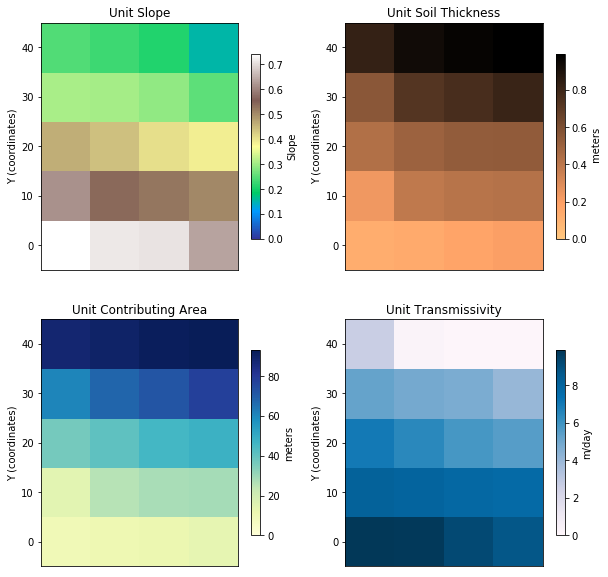

In [29]:
fields=['topographic__slope','soil__thickness','topographic__specific_contributing_area','soil__transmissivity']
maxval=[grid.at_node['topographic__slope'].max(),
        grid.at_node['soil__thickness'].max(),
        grid.at_node['topographic__specific_contributing_area'].max(),
        grid.at_node['soil__transmissivity'].max(),]
subtitles=['Unit Slope','Unit Soil Thickness','Unit Contributing Area','Unit Transmissivity']
colors=['terrain','copper_r','YlGnBu','PuBu']
scalelabel=['Slope',' meters','meters','m/day']

pl.plot_landslide_4variables([221,222,223,224],
                          grid,grid,grid,grid,
                          fields,maxval,
                          subtitles,colors,scalelabel)

In [30]:
#Wet Scenario solving for distribution of values
T = grid['node']['soil__transmissivity']
theta = np.sin(np.arctan(grid['node']['topographic__slope']))
hs = grid['node']['soil__thickness'] 
a_unit = grid['node']['topographic__specific_contributing_area']

#Select a test to compare R and D min/max bounds
Scenario="Wet" #used for labeling
rel_wet = 0.75
[Scenario_R,Scenario_D]=pl.scenario_unit_explorer(rel_wet,Scenario,a_unit,T,theta,hs)
print("")
print("The default depth inputs (min/max/mean/std): Scenario_D = {value}".format(value=Scenario_D))

For the Wet scenario with relative wetness = 0.75
 Mean topographic__specific_contributing_area= 47.95 
Recharge min, max, mean, std  [0.14498080062006399, 440.94310542569133, 108.34261453675836, 136.12911524137343] [min,max,mean,std] meters/day
Depth min, max, mean, std  [0.032910438504743109, 0.24874702843171603, 0.13433758308969157, 0.068923252607862764] [min,max,mean,std] meters
Remin = 0.144980800620064 
Remean = 108.34261453675836 
Restandard_deviation = 136.12911524137343 
Remax = 440.94310542569133 
Relative Wetness from Recharge= [ 750.  750.  750.  750.  750.  750.  750.  750.  750.  750.  750.  750.
  750.  750.  750.  750.  750.  750.  750.  750.] 

Depth to groundwater= [ 0.03291044  0.03701786  0.04414863  0.05143926  0.0593492   0.09738179
  0.10436271  0.1059291   0.10887422  0.12538828  0.13391357  0.13437227
  0.13991054  0.18195963  0.19197927  0.2032543   0.20756149  0.23483381
  0.24341827  0.24874703] 
Height of water= [ 0.09873132  0.11105359  0.13244589  0.15431

In [31]:
distribution = 'uniform'
n=25

In [32]:
LS_prob = LandslideProbability(grid,number_of_iterations=n,
    groundwater__depth_distribution=distribution,
    groundwater__depth_min_value=Scenario_D[0],
    groundwater__depth_max_value=Scenario_D[1])

LS_prob.grid["node"]["landslide__probability_of_failure"]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [33]:
LS_prob.calculate_landslide_probability()
LS_prob.grid["node"]["landslide__probability_of_failure"]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.84,  1.  ,  0.  ,  0.  ,
        0.52,  0.36,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ])

In [34]:
print("When RW = {value}, Unit Test Mean Depth to Water Table = {value2} m".format(value=0.75, value2=round(Scenario_D[2],2)))
print("When RW = {value}, Unit Test Mean Recharge = {value2} mm/day".format(value=0.75, value2=round(Scenario_R[2])))


When RW = 0.75, Unit Test Mean Depth to Water Table = 0.13 m
When RW = 0.75, Unit Test Mean Recharge = 108.0 mm/day


### Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety values using a Monte Carlo simulation approach, which randomly selects input values from parameter distributions. You can pick the number of iterations to run Monte Carlo simulations, but the default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure result becomes.<br /> 
##### Random iterations Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the number of iterations of your choice.  

In [35]:
n = 25

## Specify Recharge Distributions to compare four options

There are _four_ different options for providing recharge for the Monte Carlo simulation.  We'll provide each of these recharge options below by specifying a recharge distribution and the necessary parameters. <br /> 
##### Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cells below to adjust the recharge distributions.

 ### 1. Recharge and Depth Options - 'uniform' distribution 

In this option, we'll apply a uniform distribution of recharge and depth based on minimum and maximum recharge and depth values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and depth and instantiating the component.


# Unit test calculations 
Given one input value for recharge and depth forcings (meters)
to solve for one value of relative wetness 
then use the resulting Rw to back calculate and solve for the given forcing
Expected output: algorithms solve the equations given a known value

In [36]:
# See soil thickness above set from a range of 0.1 to 3 meters

distribution1 = 'uniform'
grid_r1 = test.test_build_grid_unitarea()
grid_d1 = test.test_build_grid_unitarea()

LS_prob1_r = LandslideProbability(grid_r1,number_of_iterations=n,
    groundwater__recharge_distribution=distribution1,
    groundwater__recharge_min_value=Scenario_R[0],
    groundwater__recharge_max_value=Scenario_R[1])

LS_prob1_d = LandslideProbability(grid_d1,number_of_iterations=n,
    groundwater__depth_distribution=distribution1,
    groundwater__depth_min_value=Scenario_D[0],
    groundwater__depth_max_value=Scenario_D[1])


In [37]:
grid_d1.at_node['soil__minimum_total_cohesion']

array([771,  58,  59, 359, 199, 425, 202, 121, 877, 162, 241, 555,  91,
       291, 501,  71, 665, 704, 121, 486])

In [38]:
LS_prob1_d.input_var_names

('soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area')

### 2. Recharge and Depth Options - 'lognormal' distribution

In this option, we specify a lognormal distribution with a recharge and depth mean and standard deviation values.  We instantiate the LandslideProbabilty class to create a new object or 'instance' of the class/component LandslideProbability. So now we have created two instances.

In [39]:
distribution2 = 'lognormal'
grid_r2 = test.test_build_grid_unitarea()
grid_d2 = test.test_build_grid_unitarea()

LS_prob2_r = LandslideProbability(grid_r2,number_of_iterations=n,
    groundwater__recharge_distribution=distribution2,
    groundwater__recharge_mean=Scenario_R[2],
    groundwater__recharge_standard_deviation=Scenario_R[3])

LS_prob2_d = LandslideProbability(grid_d2,number_of_iterations=n,
    groundwater__depth_distribution=distribution2,
    groundwater__depth_mean=Scenario_D[2],
    groundwater__depth_standard_deviation=Scenario_D[3])

### 3. Recharge and Depth Options - 'lognormal_spatial' distribution

Similar to the previous option (#2), we use a lognormal distribution for recharge and depth.  However, in this case we provide arrays to represent mean and standard deviation values for each node in our grid.  Thus, the distribution varies for each node - representing a spatially varying distribution of recharge and depth.

In [40]:
distribution3 = 'lognormal_spatial'
grid_r3 = test.test_build_grid_unitarea()
grid_d3 = test.test_build_grid_unitarea()

Remean3 = np.random.uniform(Scenario_R[0],Scenario_R[1],gridnum)
Restandard_deviation3 = np.random.rand(gridnum)
LS_prob3_r = LandslideProbability(grid_r3,number_of_iterations=n,
    groundwater__recharge_distribution=distribution3,
    groundwater__recharge_mean=Remean3,
    groundwater__recharge_standard_deviation=Restandard_deviation3)

Demean3 = np.random.uniform(Scenario_D[0],Scenario_D[1],gridnum)
Destandard_deviation3 = np.random.rand(gridnum)
LS_prob3_d = LandslideProbability(grid_d3,number_of_iterations=n,
    groundwater__depth_distribution=distribution3,
    groundwater__depth_mean=Demean3,
    groundwater__depth_standard_deviation=Destandard_deviation3)


### 4. Recharge and Depth 'data_driven_spatial' distributions 

### Generate Recharge input option 

This is the most complex representation of recharge used in the LandslideProbability component.  
In this case, we provide recharge distributions (arrays) directly that are unique for each node.  

In a real-world situation, we would acquire these from a hydrologic model that often has a coarser resolution than our grid.<br />
Thus, we route the recharge data arrays from these larger Hydraulic Source Domain (HSD) grids down to each node of our grid. Landlab has a 'Source tracking algorithm' utility that performs this routing and produces Python dictionaries (_key: value_ pairs) that become parameters for the 'data_driven_spatial' recharge distribution.  In this synthetic example, we'll generate synthetic versions of these dictionaries.

In [41]:
HSD_dict = {}
for vkey in range(2,8):  #the first example vkey =2 is printed below
    HSD_dict[vkey] = np.random.uniform(Scenario_R[0],Scenario_R[1],10)    # 20 - 120 mm/day 
print('HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). ')    
print('The entire synthetic dictionary is:')
print(HSD_dict)
print('The array for the HSD vkey = 2 of this unordered dictionary is:')
print(HSD_dict[2])

HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). 
The entire synthetic dictionary is:
{2: array([ 242.0609441 ,  315.39911225,  265.84194657,  240.32846601,
        186.89122184,  284.85389455,  193.03260289,  393.23684714,
        424.9257184 ,  169.1652832 ]), 3: array([ 349.13589281,  233.28086955,  250.53795803,  408.14624312,
         31.45754204,   38.55141271,    9.05721248,  367.16224724,
        343.15501728,  383.64470415]), 4: array([ 431.51811078,  352.41257719,  203.56421823,  344.20077792,
         52.28012591,  282.22096691,   63.33484105,  416.55326783,
        230.17474237,  182.9271863 ]), 5: array([ 116.76059848,  341.42573912,  201.21519179,  250.70959944,
          8.4274896 ,  272.39754961,  269.95562747,  272.08832964,
        416.14736393,  300.69008998]), 6: array([ 158.61538916,  192.78784644,  307.65950365,   26.69225575,
        294.05449853,  295.76089603,   92.88121918,

***Note: this is a much lower recharge than the uniform.

HSD_ID dictionary has the grid node ID as ‘keys’ and HSD IDs in a list as ‘values’. 

In [42]:
HSD_id_dict = {}
for ckey in grid.core_nodes:
    HSD_id_dict[ckey] = np.random.randint(2,8,2)
print('The entire ID synthetic dictionary is:')
print(HSD_id_dict)
print('The array for the ckey = 5, the first index of core nodes in the dictionary is:')
print(HSD_id_dict[5])
print('The two values in the array are the multiple vkeys that correspond/drain to the ckey:')


The entire ID synthetic dictionary is:
{5: array([7, 7]), 6: array([7, 2]), 9: array([3, 7]), 10: array([3, 5]), 13: array([2, 7]), 14: array([2, 3])}
The array for the ckey = 5, the first index of core nodes in the dictionary is:
[7 7]
The two values in the array are the multiple vkeys that correspond/drain to the ckey:


The fractions dictionary assigns to each node ID as ‘key’ a lists the fractions of each HSD draining to the node as ‘values’. 

In [43]:
fract_dict = {}
for ckey in grid.core_nodes:
    fract_dict[ckey] =  np.random.rand(2)
print('The entire ID synthetic dictionary is:')
print(fract_dict)
print('The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:')
print(fract_dict[5])

The entire ID synthetic dictionary is:
{5: array([ 0.83794491,  0.09609841]), 6: array([ 0.97645947,  0.4686512 ]), 9: array([ 0.97676109,  0.60484552]), 10: array([ 0.73926358,  0.03918779]), 13: array([ 0.28280696,  0.12019656]), 14: array([ 0.2961402 ,  0.11872772])}
The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:
[ 0.83794491  0.09609841]


When the component is instantiated, the three dictionaries are provided as the 'parameters' for the distribution in explicit order.

### Generate Depth to water table Input option

In [44]:
key=np.arange(grid.number_of_nodes)
HSD_inputs_d={}

for i in range(grid.number_of_nodes):
    annualmaxDWT=np.random.uniform(Scenario_D[0],Scenario_D[1],10)
    HSD_inputs_d[i] = (annualmaxDWT)

#print(HSD_inputs_d)
print('The values assigned to the first node (key) are: ')
print(HSD_inputs_d[0])

The values assigned to the first node (key) are: 
[ 0.10154284  0.12232355  0.04675582  0.18237126  0.15520376  0.0901912
  0.14584651  0.05318624  0.15722077  0.23348656]


### Calculate landslide component input distributions

In [45]:
distribution4 = 'data_driven_spatial'
grid_r4 = test.test_build_grid_unitarea()
grid_d4 = test.test_build_grid_unitarea()

HSD_inputs_r = [HSD_dict,HSD_id_dict,fract_dict]
LS_prob4_r = LandslideProbability(grid_r4,number_of_iterations=n,
    groundwater__recharge_distribution=distribution4,
    groundwater__recharge_HSD_inputs=HSD_inputs_r)

LS_prob4_d = LandslideProbability(grid_d4,number_of_iterations=n,
    groundwater__depth_distribution=distribution4,
    groundwater__depth_HSD_inputs=HSD_inputs_d)


## Run the Landslide Component 

To generate the outputs from running the component, we call the 'calculate_landslide_probability' method inside the component using the class instance (e.g., LS_prob1) for each recharge option specified above. The following cell runs the model; in the following section we will assessing the results.

###  Run the Landslide Component in Default Parameters for Depth Forcing Uniform Distribution

Uniform recharge; default parameters.

Running the unit test cell will give the same solution each time you run the same grid is created inside the test, every time the test model is run. 

These model output arrays are attached to the grid as fields. When we run the model for a different recharge, these fields are over-written. 

###  Run the Landslide Component and Save Outputs for Four Different Modes

Run the remaining three recharge options and save the arrays as variables for plotting.

**Unit Tests** for Landslide Probability calculations using four variations of statistical and data generated forcings for recharge and depth.

`test_calculate_landslide_probability_uniform_depth_method()`
and 
`test_calculate_landslide_probability_uniform_recharge_method()` 

In [46]:
LS_prob_test_d1=test.test_calculate_landslide_probability_uniform_depth_method()

In [47]:
grid_test_d1=LS_prob_test_d1.grid
print("Unit test core node 6 = {value}".format(value=grid_test_d1.at_node["landslide__probability_of_failure"][5]))
print("Unit test core node 10 = {value}".format(value=grid_test_d1.at_node["landslide__probability_of_failure"][9]))


Unit test core node 6 = 0.84
Unit test core node 10 = 0.52


Running this cell will give a similar but new solution each time you run the model since a new grid is passed into the function each time you run the cell (from LS_prob1_d)

In [48]:
test.print_failure_nodevalues(LS_prob_test_d1)
test.print_testcore_nodevalues(LS_prob_test_d1)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.84  1.    0.    0.    0.52  0.36  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.84
Unit test core node 10 = 0.52


The outputs of model simulations are:

In [49]:
LS_prob_test_r1=test.test_calculate_landslide_probability_uniform_recharge_method()
grid_test_r1=LS_prob_test_r1.grid
test.print_failure_nodevalues(LS_prob_test_r1)
test.print_testcore_nodevalues(LS_prob_test_r1)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.92  0.92  0.    0.    0.92  0.96  0.
  0.    0.08  0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.92
Unit test core node 10 = 0.92


In [50]:
LS_prob1_d=test.test_calculate_landslide_probability_uniform_depth_method()
LS_prob1_r=test.test_calculate_landslide_probability_uniform_recharge_method()

In [51]:
test.print_list_nodevalues(LS_prob1_d,['landslide__probability_of_failure'])
test.print_list_nodevalues(LS_prob1_r,['landslide__probability_of_failure'])

Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    0.84  1.    0.    0.    0.52  0.36  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    0.92  0.92  0.    0.    0.92  0.96  0.
  0.    0.08  0.    0.    0.    0.    0.    0.  ]



In [52]:
test.test_calculate_landslide_probability_lognormal_depth_method()

In [63]:
LS_prob_test_d2=test.test_calculate_landslide_probability_lognormal_depth_method()
grid_test_d2=LS_prob_test_d2.grid
test.print_failure_nodevalues(LS_prob_test_d2)
test.print_testcore_nodevalues(LS_prob_test_d2)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.84  0.92  0.    0.    0.6   0.24  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.84
Unit test core node 10 = 0.6


In [64]:
LS_prob_test_r2=test.test_calculate_landslide_probability_lognormal_recharge_method()
grid_test_r2=LS_prob_test_r2.grid
test.print_failure_nodevalues(LS_prob_test_r2)
test.print_testcore_nodevalues(LS_prob_test_r2)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.88  0.92  0.    0.    0.88  0.8   0.
  0.    0.04  0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.88
Unit test core node 10 = 0.88


In [69]:
LS_prob_test_d3=test.test_calculate_landslide_probability_lognormal_spatial_depth_method()
grid_test_d3=LS_prob_test_d3.grid
test.print_failure_nodevalues(LS_prob_test_d3)
test.print_testcore_nodevalues(LS_prob_test_d3)

LS_prob3_r_unit=test.test_calculate_landslide_probability_lognormal_spatial_recharge_method()
grid_test_r3=LS_prob3_r_unit.grid
test.print_failure_nodevalues(LS_prob3_r_unit)
test.print_testcore_nodevalues(LS_prob3_r_unit)


Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.72  0.76  0.    0.    0.96  0.6   0.
  0.    0.04  0.08  0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.72
Unit test core node 10 = 0.96
Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    1.    1.    0.    0.    1.    0.92  0.
  0.    0.08  0.08  0.    0.    0.    0.    0.  ]

Unit test core node 6 = 1.0
Unit test core node 10 = 1.0


**Use Unit Test function** to calculate data driven spatial failure probability with two methods (depth, recharge)

In [80]:
LS_prob_test_d4=test.test_calculate_landslide_probability_datadriven_spatial_depth_method()
grid_test_d4=LS_prob_test_d4.grid
LS_prob_test_r4=test.test_calculate_landslide_probability_datadriven_spatial_recharge_method()
grid_test_r4=LS_prob_test_r4.grid
print("Recharge Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob_test_r4)
test.print_testcore_nodevalues(LS_prob_test_r4)
print("")
print("Depth Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob_test_d4)
test.print_testcore_nodevalues(LS_prob_test_d4)

Recharge Hydrologic Forcing
Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.96  0.84  0.    0.    0.84  1.    0.
  0.    0.08  0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.96
Unit test core node 10 = 0.84

Depth Hydrologic Forcing
Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.96  0.96  0.    0.    0.88  0.32  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.96
Unit test core node 10 = 0.88


# Plot Unit Tests

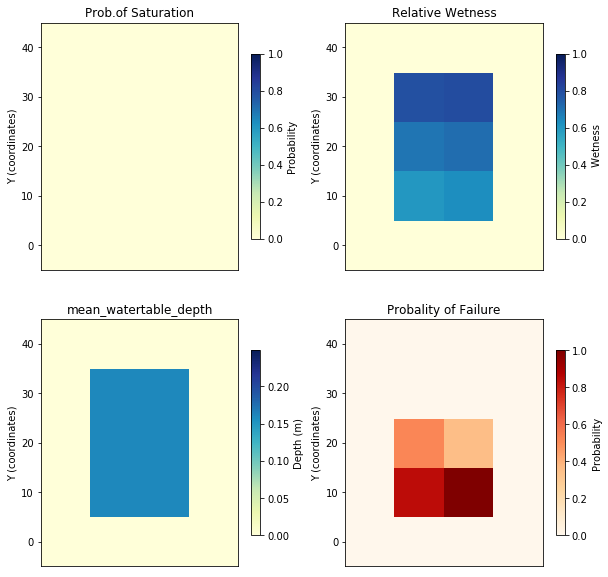

In [81]:
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_watertable_depth','landslide__probability_of_failure']
maxval=[1,1, Scenario_D[1],1,]
subtitles=['Prob.of Saturation','Relative Wetness','mean_watertable_depth','Probality of Failure']
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Depth (m)','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          grid_test_d1,grid_test_d1,grid_test_d1,grid_test_d1,
                          fields,maxval,
                          subtitles,colors,scalelabel)

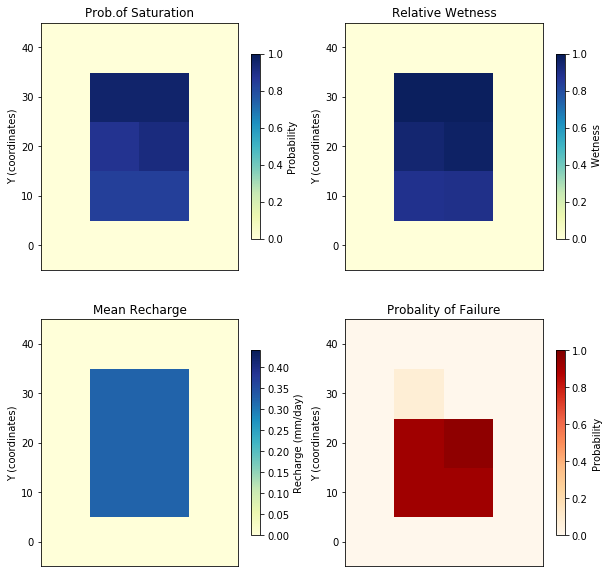

In [82]:
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_recharge','landslide__probability_of_failure']
maxval=[1,1, Scenario_R[1]/1000,1,]
subtitles=['Prob.of Saturation','Relative Wetness','Mean Recharge','Probality of Failure']
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Recharge (mm/day)','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          grid_test_r1,grid_test_r1,grid_test_r1,grid_test_r1,
                          fields,maxval,
                          subtitles,colors,scalelabel)

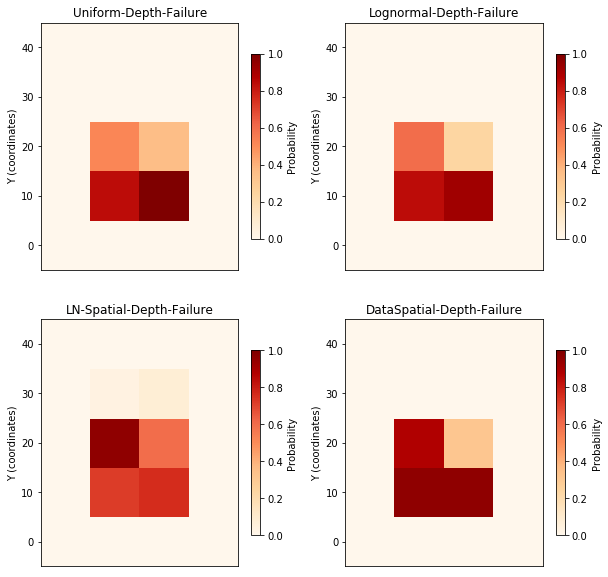

In [83]:
fields=['landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure']
maxval=[1,1,1,1,]
subtitles=['Uniform-Depth-Failure','Lognormal-Depth-Failure','LN-Spatial-Depth-Failure','DataSpatial-Depth-Failure']
colors=['OrRd','OrRd','OrRd','OrRd']
scalelabel=['Probability','Probability','Probability','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          grid_test_d1,grid_test_d2,grid_test_d3,grid_test_d4,
                          fields,maxval,
                          subtitles,colors,scalelabel)

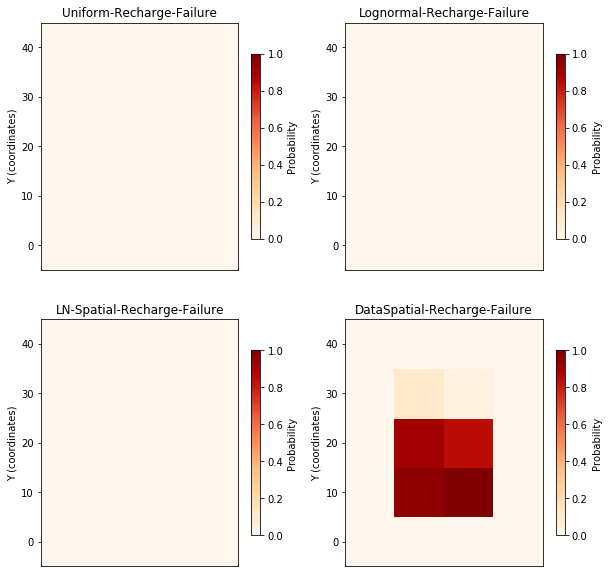

In [84]:
fields=['landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure']
maxval=[1,1,1,1,]
subtitles=['Uniform-Recharge-Failure','Lognormal-Recharge-Failure','LN-Spatial-Recharge-Failure','DataSpatial-Recharge-Failure']
colors=['OrRd','OrRd','OrRd','OrRd']
scalelabel=['Probability','Probability','Probability','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          grid_test_r1,grid_test_r2,grid_test_r3,grid_test_r4,
                          fields,maxval,
                          subtitles,colors,scalelabel)

**Use Landslide Component** to calculate data driven spatial failure probability with two methods (depth, recharge) **different results are expected each time this is run**

In [85]:
print("Recharge Hydrologic Forcing")
LS_prob4_r.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob4_r,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob4_r)
print("Depth Hydrologic Forcing")
LS_prob4_d.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob4_d,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob4_d)

Recharge Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    1.    1.    0.    0.    0.92  0.8   0.
  0.    0.24  0.    0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    1.    1.    0.    0.    0.92  0.8   0.
  0.    0.24  0.    0.    0.    0.    0.    0.  ]

Depth Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    0.96  0.88  0.    0.    0.64  0.36  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.96  0.88  0.    0.    0.64  0.36  0.
  0.

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:200px;padding:20px">   


The development of this Notebook has been made possible by the Landlab project funded by the National Science Foundation (OAC 1450338 to N. Gasparini, OAC 1450409 to G. Tucker, OAC 1450412 to E. Istanbulluoglu).